# Prediksi Fluktuasi Harga Saham


Proyek ini bertujuan untuk memprediksi apakah harga saham akan naik atau turun berdasarkan data-data historis. Program ini menggunakan model Random Forest karena model ini mampu menangani data non-linear dengan baik. Hasil akhir dari program ini adalah menunjukkan apakah harga saham suatu perusahaan naik atau turun pada hari tersebut. Proyek ini dibagi menjadi 2 tahap, tahap pertama adalah pembuatan model awal dan tahap kedua adalah dengan menambahkan fitur dan tuning untuk meningkatkan performa model. 

---

# Import Libraries

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score

## Data Loading

Data yang digunakan dalam program ini adalah data historis harga saham **Bank Mandiri** yang berasal dari libraries **yfinance**. Data diambil dari awal hingga hari ini.

In [25]:
df = yf.Ticker("BMRI.JK").history(period='max')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2003-07-14 00:00:00+07:00,83.323284,94.074673,83.323284,91.386826,2396676086,0.0,0.0
2003-07-15 00:00:00+07:00,94.074673,96.762520,91.386826,91.386826,841825534,0.0,0.0
2003-07-16 00:00:00+07:00,91.386822,91.386822,88.698975,88.698975,147014628,0.0,0.0
2003-07-17 00:00:00+07:00,88.698979,91.386826,88.698979,91.386826,222191824,0.0,0.0
2003-07-18 00:00:00+07:00,88.698979,91.386826,88.698979,91.386826,82279783,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-13 00:00:00+07:00,6025.000000,6100.000000,5975.000000,6025.000000,135581400,0.0,0.0
2024-12-16 00:00:00+07:00,5900.000000,6100.000000,5900.000000,6075.000000,105375900,0.0,0.0
2024-12-17 00:00:00+07:00,6050.000000,6075.000000,5925.000000,5950.000000,72109300,0.0,0.0


<Axes: xlabel='Date'>

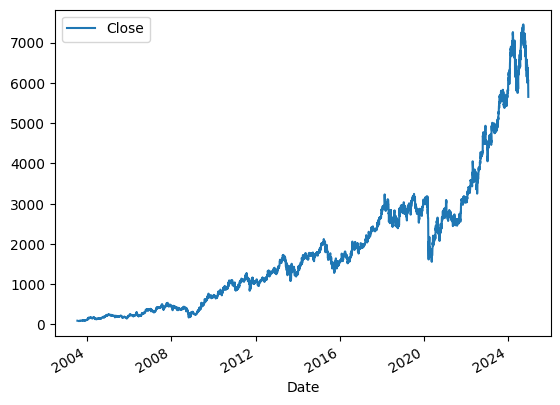

In [26]:
# Menampilkan grafik pergerakan harga saham
df.plot.line(y='Close')

In [27]:
# Menghapus data yang tidak diperlukan
df = df.drop(['Dividends', 'Stock Splits'], axis=1)  

In [28]:
# menambahkan kolom target, dimana kolom ini menunjukkan apakah harga saham hari ini naik atau turun dari hari sebelumnya, 
# kenaikan diwakili angka 1 dan penurunan diwakili angka 0
df['Target'] = (df['Close'] > df['Close'].shift(1)).astype(int)

In [29]:
# membagi dataset untuk pengujian dan pelatihan
X = df.drop(['Target'], axis=1)
y = df['Target']

# Membagi data: 80% untuk train, 20% untuk test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train data shape:", X_train.shape, y_train.shape)
print("Test data shape:", X_test.shape, y_test.shape)

Train data shape: (4253, 5) (4253,)
Test data shape: (1064, 5) (1064,)


In [30]:
# membuat pipeline untuk preprocessing dan model

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=32))
])

# melatih model
pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('rf', RandomForestClassifier(random_state=32))])

In [31]:
# Evaluasi model pada data train dan test

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

print('Precision Score Train')
print(precision_score(y_train, y_train_pred))
print('Precision Score Test')
print(precision_score(y_test, y_test_pred))

Precision Score Train
1.0
Precision Score Test
0.5861182519280206


In [32]:
# membuat fungsi untuk melakukan prediksi pada data

def predict(data, model):
    X = data.drop(['Target'], axis=1)
    return pd.Series(model.predict(X), index=data.index, name='Predictions')

In [33]:
# membuat fungsi untuk backtesting model, backtest dilakukan untuk menilai bagaimana kinerja model jika diterapkan pada data nyata di masa lalu
# data ini dimulai dengan memproses 3650 baris (data 10 tahun terakhir) 
# dilanjutkan dengan stepnya setiap satu tahun (365 hari) 

def backtest(data, model, start=3650, step=365):
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Train model on training data
        X_train = train.drop(['Target'], axis=1)
        y_train = train['Target']
        model.fit(X_train, y_train)

        # Predict on test data
        predictions = predict(test, model)
        combined = pd.concat([test, predictions], axis=1)
        all_predictions.append(combined)

    return pd.concat(all_predictions)

In [34]:
# eksekusi backtest
df = df.dropna()  # Ensure no missing values
predictions = backtest(df, pipeline)


In [35]:
# Menampilkan nilai atau tingkat presisi model
precisions = precision_score(predictions["Target"], predictions["Predictions"])
print(precisions)

0.5370370370370371


In [36]:
# Menambahkan beberapa variabel yang bertujuan untuk meningkatkan nilai precisions pada model

df2 = df.copy()

# MA adalah Moving Average atau rata-rata bergerak yang berfungsi untuk memberi gambaran lebih jauh mengenai fluktuasi harga jangka pendek
# MA10 adalah untuk jangka waktu 10 hari, dan MA50 untuk 50 hari
# Volatility adalah deviasi standar dari harga penutupan (Close) selama 10 periode terakhir. 
# Semakin tinggi volatilitas, semakin tidak stabil harga, yang biasanya berarti risiko lebih besar

df2['MA10'] = df2['Close'].rolling(window=10).mean()
df2['MA50'] = df2['Close'].rolling(window=50).mean()
df2['Volatility'] = df2['Close'].rolling(window=10).std()


In [37]:
# membagi data train dan test untuk model yang akan menggunakan data tambahan 
X_2 = df2.drop('Target', axis=1)
y_2 = df2['Target']

# Membagi data: 80% untuk train, 20% untuk test
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train data shape:", X_train_2.shape, y_train_2.shape)
print("Test data shape:", X_test_2.shape, y_test_2.shape)

Train data shape: (4253, 5) (4253,)
Test data shape: (1064, 5) (1064,)


In [38]:
# membuat pipeline baru
pipeline_2 = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(n_estimators=300, random_state=32))
])

pipeline_2.fit(X_train_2, y_train_2)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(n_estimators=300, random_state=32))])

In [39]:
# Evaluasi model baru pada data train dan test
y_train_pred_2 = pipeline_2.predict(X_train_2)
y_test_pred_2 = pipeline_2.predict(X_test_2)

print('Precision Score Train')
print(precision_score(y_train_2, y_train_pred_2))
print('Precision Score Test')
print(precision_score(y_test_2, y_test_pred_2))

Precision Score Train
1.0
Precision Score Test
0.6040100250626567


In [40]:
# membuat fungsi untuk melakukan prediksi pada data
def predict(data, model):
    X = data.drop(['Target'], axis=1)
    return pd.Series(model.predict(X), index=data.index, name='Predictions')

In [41]:
# membuat fungsi untuk backtesting model
def backtest(data, model, start=3650, step=365):
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Train model on training data
        X_train = train.drop(['Target'], axis=1)
        y_train = train['Target']
        model.fit(X_train, y_train)

        # Predict on test data
        predictions = predict(test, model)
        combined = pd.concat([test, predictions], axis=1)
        all_predictions.append(combined)

    return pd.concat(all_predictions)

In [42]:
# Eksekusi Backtest
df2 = df2.dropna()  # Ensure no missing values
predictions_2 = backtest(df2, pipeline_2)

In [43]:
# Menampilkan nilai atau tingkat presisi model
precisions_2 = precision_score(predictions_2["Target"], predictions_2["Predictions"])
print(precisions_2)

0.5516074450084603


In [44]:
# Membandingkan hasil kedua model
comparison = pd.DataFrame({
    'Model': ['Model 1 (Tanpa Kolom Baru)', 'Model 2 (Dengan Kolom Baru)'],
    'Precision Test': [precision_score(y_test, y_test_pred), precision_score(y_test_2, y_test_pred_2)],
    'Precision Backtest': [precisions, precisions_2]
})

print(comparison)

                         Model  Precision Test  Precision Backtest
0   Model 1 (Tanpa Kolom Baru)        0.586118            0.537037
1  Model 2 (Dengan Kolom Baru)        0.604010            0.551607


In [45]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'min_samples_split': [10, 50, 100],
    'max_depth': [None, 10, 20]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='precision')
grid_search.fit(X_train_2, y_train_2)
best_model = grid_search.best_estimator_

# Menampilkan parameter terbaik
print("Best Parameters:", grid_search.best_params_)

# Menampilkan nilai precision terbaik dari hasil GridSearchCV
print("Best Precision Score:", grid_search.best_score_)


Best Parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
Best Precision Score: 0.57235250311829


In [46]:
# Evaluasi pada test set
y_test_pred = best_model.predict(X_test)
test_precision = precision_score(y_test, y_test_pred)

print("Test Precision of Best Model:", test_precision)


Test Precision of Best Model: 0.5826771653543307


In [54]:
# Menampilkan hasil prediksi model dalam bentuk data
predictions = backtest(df2, best_model)
predictions.head(10)

,Open,High,Low,Close,Volume,Target,MA10,MA50,Volatility,Predictions
Date,,,,,,,,,,
2018-05-30 00:00:00+07:00,2782.959494,2937.033376,2754.070641,2792.589111,170628800,0,2676.070776,2861.100967,116.836604,1
2018-05-31 00:00:00+07:00,2850.366897,2850.366897,2705.922628,2715.552246,211020800,0,2689.552246,2858.343228,112.304146,0
2018-06-01 00:00:00+07:00,2715.552246,2715.552246,2715.552246,2715.552246,0,0,2699.181836,2852.221904,109.705255,0
2018-06-04 00:00:00+07:00,2734.811272,2859.996295,2734.811272,2840.737061,80221000,1,2726.144751,2848.416606,107.848737,1
2018-06-05 00:00:00+07:00,2869.626138,2869.626138,2802.218812,2831.107666,73520200,0,2757.922461,2844.981758,81.861169,0
2018-06-06 00:00:00+07:00,2811.848166,2840.737017,2811.848166,2821.477783,72158600,0,2779.107617,2842.855732,64.867946,0
2018-06-07 00:00:00+07:00,2840.737061,2850.366678,2821.477826,2840.737061,49787600,1,2793.552026,2840.544619,60.299407,0
2018-06-08 00:00:00+07:00,2850.366808,2850.366808,2677.033691,2677.033691,134418800,0,2791.626099,2834.959438,63.948132,0
2018-06-11 00:00:00+07:00,2677.033691,2677.033691,2677.033691,2677.033691,0,0,2775.255762,2828.218701,70.587949,0


# Kesimpulan

Berdasarkan kedua model yang telah dibuat dapat dilihat terdapat perbedaan nilai precision pada keduanya. Model awal yang hanya menggunakan data asli mendapatkan nilai precision sebesar **53,7037%**. Kemudian dilakukan penambahan fitur untuk meningkatkan nilai precision pada model Random Forest tersebut. Fitur yang ditambahkan adalah Moving Average yang berada dalam jangka waktu 10 hari dan 50 hari, serta volatilitas. Setelah fitur-fitur tersebut ditambahkan pada data dan model dijalankan, ternyata peningkatannya tidak signifikan. Peningkatannya hanya berubah dari **53,7037%** menjadi **55,1607%**.

Kemudian dilakukan pencarian parameter terbaik untuk model dengan menggunakan Grid Search dan didapati nilai-nilai berikut sebagai parameter terbaik :
- max_depth : 20
- min_samples_split : 10
- n_estimators : 300

Setelah itu model dijalankan kembali menggunakan parameter tersebut namun hasiilnya masih kurang maksimal karena nilainya menjadi **58,2677%**

Beberapa hal yang dapat dilakukan kedepannya untuk meningkatkan nilai precision pada model:
- Menambahkan fitur lainnya yang dapat membantu model untuk belajar
- Mengganti model lain yang mungkin lebih sesuai seperti model dengan basis time series
- Melakukan tuning hyperparameter lebih lanjut